## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

## Load data
The dataset is the Heart Disease Data Set from UCI Machine Learning Repository. It is a binary classifiation dataset, the label is stored in `target` column. **Please note that there exist categorical features which need to be [one-hot encoding](https://www.datacamp.com/community/tutorials/categorical-data) before fit into your model!**
See follow links for more information
https://archive.ics.uci.edu/ml/datasets/heart+Disease

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score

file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

df_onehot = pd.get_dummies(df, columns=['thal'])

train_idx = np.load('train_idx.npy')
test_idx = np.load('test_idx.npy')

x_train = df.iloc[train_idx]
x_test = df.iloc[test_idx]

train_df = np.array(df_onehot.iloc[train_idx])
test_df = np.array(df_onehot.iloc[test_idx])

y_train_df = train_df[:, 12]
y_test_df = test_df[:, 12]

train_df = np.concatenate((train_df[:, 0:11], train_df[:, 15:17]), axis=1)
test_df = np.concatenate((test_df[:, 0:11], test_df[:, 15:17]), axis=1)



## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [2]:
def gini(sequence):
    sequence_1 = sequence[np.where(sequence == 1)]
    sequence_2 = sequence[np.where(sequence == 2)]
    p_1 = sequence_1.size / sequence.size
    p_2 = sequence_2.size / sequence.size
    return 1 - p_1 ** 2 - p_2 ** 2

def entropy(sequence):
    sequence_1 = sequence[np.where(sequence == 1)]
    sequence_2 = sequence[np.where(sequence == 2)]
    p_1 = sequence_1.size / sequence.size
    p_2 = sequence_2.size / sequence.size
    return -(p_1 * np.log2(p_1) + p_2 * np.log2(p_2))

In [3]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [4]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [5]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


### Question 2.1
Using `criterion=gini`, showing the accuracy score of test data by `max_depth=3` and `max_depth=10`, respectively.


In [6]:
# The node used in decision tree
class Node:
    def __init__(self, gini, entropy, num_samples,
                 num_samples_per_class, predicted_class):
        self.gini = gini
        self.entropy = entropy
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

In [7]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        self.max_depth = max_depth
        self.criterion = criterion
        self.feature_list = []

    def fit(self, X, y):
        self.classess = np.unique(y).size
        self.features = X.shape[1]
        self.tree = self.insert_tree(X, y)

    def gini_(self, sequence):  # Calculate the Gini index
        sequence_0 = sequence[np.where(sequence == 0)]
        sequence_1 = sequence[np.where(sequence == 1)]
        p_0 = sequence_0.size / sequence.size
        p_1 = sequence_1.size / sequence.size
        return 1 - p_0 ** 2 - p_1 ** 2

    def entropy_(self, sequence):  # Calculate the entropy
        sequence_0 = sequence[np.where(sequence == 0)]
        sequence_1 = sequence[np.where(sequence == 1)]
        p_0 = sequence_0.size / sequence.size
        p_1 = sequence_1.size / sequence.size
        return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))

    # Find the best split
    def best_split(self, X, y, criterion):
        if y.size <= 1:
            return None, None

        best_gini = self.gini_(y)
        best_entropy = self.entropy_(y)
        thrsh, feature_idx = None, None

        for i in range(X.shape[1]):  # number of features
            feature_sorted = sorted(np.unique(X[:, i]))  # sort unique value
            for j in range(len(feature_sorted)-1):  # number of unique values
                # I first found the number of unique values and sorted them,
                # and then calcualted the mean between two values as threshold
                midpoint = (feature_sorted[j] + feature_sorted[j+1]) / 2
                # If the value is less than threshold,
                # it will belong to the left
                left_X = X[np.where(X[:, i] < midpoint), :]
                left_y = y[np.where(X[:, i] < midpoint)]
                # If the value is greater than threshold,
                # it will belong to the left
                right_X = X[np.where(X[:, i] > midpoint), :]
                right_y = y[np.where(X[:, i] > midpoint)]
                if (criterion == 'gini'):
                    gini_left = self.gini_(left_y)
                    gini_right = self.gini_(right_y)
                    gini_temp = (gini_left * left_y.size +
                                 gini_right * right_y.size) / y.size
                    if (gini_temp < best_gini):
                        best_gini = gini_temp
                        thrsh = midpoint
                        # The i-th column of x is the feature
                        # used to split the node
                        feature_idx = i
                else:
                    entropy_left = self.entropy_(left_y)
                    entropy_right = self.entropy_(right_y)
                    entropy_temp = (entropy_left * left_y.size +
                                    entropy_right * right_y.size) / y.size
                    if (entropy_temp < best_entropy):
                        best_entropy = entropy_temp
                        thrsh = midpoint
                        feature_idx = i

        return feature_idx, thrsh

    # Build the decision tree through recursive method
    def insert_tree(self, X, y, depth=0):
        num_class_0 = y[np.where(y == 0)].size
        num_class_1 = y[np.where(y == 1)].size
        num_samples_per_class = np.array([num_class_0, num_class_1])
        # If the number of class 2 > class 1, then predict class 2
        predicted_class = np.argmax(num_samples_per_class)

        node = Node(gini=self.gini_(y),
                    entropy=self.entropy_(y),
                    num_samples=y.size,
                    num_samples_per_class=num_samples_per_class,
                    predicted_class=predicted_class,
                    )

        if self.max_depth is not None:
            if depth < self.max_depth:
                feature, thrsh = self.best_split(X, y, self.criterion)
                if feature is not None:
                    feature_left = X[:, feature] < thrsh
                    X_left, y_left = X[feature_left], y[feature_left]
                    X_right, y_right = X[~feature_left], y[~feature_left]
                    node.feature_index = feature
                    self.feature_list.append(feature)
                    node.threshold = thrsh
                    node.left = self.insert_tree(X_left, y_left, depth + 1)
                    node.right = self.insert_tree(X_right, y_right, depth + 1)
        else:
            feature, thrsh = self.best_split(X, y, self.criterion)
            if feature is not None:
                feature_left = X[:, feature] < thrsh
                X_left, y_left = X[feature_left], y[feature_left]
                X_right, y_right = X[~feature_left], y[~feature_left]
                node.feature_index = feature
                self.feature_list.append(feature)
                node.threshold = thrsh
                node.left = self.insert_tree(X_left, y_left, depth + 1)
                node.right = self.insert_tree(X_right, y_right, depth + 1)

        return node

    # This function is used to record the feature used in every node
    def feature_counter(self, X):
        idx_list_counter = np.zeros(X.shape[1])
        for i in range(len(self.feature_list)):
            idx_list_counter[self.feature_list[i]] = \
                idx_list_counter[self.feature_list[i]] + 1

        x = np.arange(len(idx_list_counter))
        features = x_train.columns[np.where(idx_list_counter != 0)]
        times = idx_list_counter[np.where(idx_list_counter != 0)]

        plt.barh(features, times)
        plt.ylabel('Features')
        plt.xlabel('Counts')
        plt.title(f'Feature importance\n\
        criterion = {self.criterion}, max depth = {self.max_depth}')
        plt.show()

    # Predict the test data
    def predict(self, test):
        predicted = []
        for data in test:
            node = self.tree
            while node.left:
                if data[node.feature_index] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            predicted.append(node.predicted_class)
        return predicted


In [8]:
clf_depth3 = DecisionTree(criterion = 'gini', max_depth = 3)
clf_depth3.fit(train_df, y_train_df)
pred_gini_depth3 = np.array(clf_depth3.predict(test_df))
acc_gini_depth3 = accuracy_score(pred_gini_depth3, y_test_df)
print(f"criterion: gini, max_depth: 3, Accuracy = {acc_gini_depth3}")


clf_depth10 = DecisionTree(criterion = 'gini', max_depth = 10)
clf_depth10.fit(train_df, y_train_df)
pred_gini_depth10 = np.array(clf_depth10.predict(test_df))
acc_gini_depth10 = accuracy_score(pred_gini_depth10, y_test_df)
print(f"criterion: gini, max_depth: 10, Accuracy = {acc_gini_depth10}")

criterion: gini, max_depth: 3, Accuracy = 0.83
criterion: gini, max_depth: 10, Accuracy = 0.78


/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: divide by zero encountered in log2
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: invalid value encountered in double_scalars
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: divide by zero encountered in log2
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: invalid value encountered in double_scalars
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))


### Question 2.2
Using `max_depth=3`, showing the accuracy score of test data by `criterion=gini` and `criterion=entropy`, respectively.

In [9]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(train_df, y_train_df)
pred_gini_depth3 = np.array(clf_depth3.predict(test_df))
acc_gini_depth3 = accuracy_score(pred_gini_depth3, y_test_df)
print(f"criterion: gini, max_depth: 3, Accuracy = {acc_gini_depth3}")

clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(train_df, y_train_df)
pred_entropy_depth3 = np.array(clf_entropy.predict(test_df))
acc_entropy_depth3 = accuracy_score(pred_entropy_depth3, y_test_df)
print(f"criterion: entropy, max_depth: 3, Accuracy = {acc_entropy_depth3}")

criterion: gini, max_depth: 3, Accuracy = 0.83
criterion: entropy, max_depth: 3, Accuracy = 0.8


/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: divide by zero encountered in log2
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: invalid value encountered in double_scalars
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: divide by zero encountered in log2
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: invalid value encountered in double_scalars
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))


- Note: Your decisition tree scores should over **0.7**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

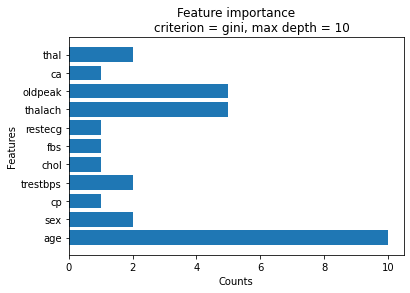

In [10]:
clf_depth10.feature_counter(train_df)
# The feature which is not in the figure is not used

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [11]:
# Decision stump used as weak classifier
class DecisionStump():
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions


class Adaboost():

    def __init__(self, n_estimators=100):
        self.n_estimators = n_estimators

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []
        # Iterate through classifiers
        for _ in range(self.n_estimators):
            clf = DecisionStump()

            min_error = float('inf')
            # greedy search to find best threshold and feature
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # predict with polarity 1
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    # Error = sum of weights of misclassified samples
                    misclassified = w[y != predictions]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # store the best configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # calculate alpha
            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # calculate predictions and update weights
            predictions = clf.predict(X)

            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred

### Question 4.1
Show the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


In [12]:
clf = Adaboost(n_estimators = 10)
clf.fit(train_df, y_train_df)
y_pred = clf.predict(test_df)
acc = 1 - accuracy_score(y_test_df, y_pred)
print(f"n_estimators: 10, Accuracy = {acc}")


n_estimators: 10, Accuracy = 0.8


In [13]:
clf = Adaboost(n_estimators = 100)
clf.fit(train_df, y_train_df)
y_pred = clf.predict(test_df)
acc = 1 - accuracy_score(y_test_df, y_pred)
print(f"n_estimators: 100, Accuracy = {acc}")

n_estimators: 100, Accuracy = 0.8


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [14]:
class RandomForest():
    def __init__(self, n_estimators, max_features,
                 bootstrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        # If the max_features is not integer
        # I round it
        self.max_features = round(max_features)
        self.bootstrap = bootstrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.tree_list = []

    # Build the random forest
    def build(self, X, y):
        # If bootstrap is true, the data may be reused
        if self.bootstrap is True:
            for b in range(self.n_estimators):
                # I random chose max_features features every time
                X_ = X[:, random.sample(range(X.shape[1]),
                                        self.max_features)]
                # I random chose 120 datas to build decision tree
                random_choose = random.sample(range(X.shape[0]), 120)
                X_ = X[random_choose, :]
                y_ = y[random_choose]
                clf = DecisionTree(self.criterion, self.max_depth)
                clf.fit(X_, y_)
                self.tree_list.append(clf)  # Record the decision tree
        else:  # If bootstrap is not true, the data will not be reused
            random_train_list = np.arange(X.shape[1])
            random.shuffle(random_train_list)
            # I divide datas into n_estimators parts
            n = round(X.shape[0] / self.n_estimators)
            for b in range(self.n_estimators - 1):
                # I random chose max_features feature every time
                X_ = X[:, random.sample(range(X.shape[1]),
                                        self.max_features)]
                X_ = X[b*n:(b+1)*n, :]
                y_ = y[b*n:(b+1)*n]
                clf = DecisionTree(self.criterion, self.max_depth)
                clf.fit(X_, y_)
                self.tree_list.append(clf)
            X_ = X[(self.n_estimators-1)*n:, :]
            y_ = y[(self.n_estimators-1)*n:]
            clf = DecisionTree(self.criterion, self.max_depth)
            clf.fit(X_, y_)
            self.tree_list.append(clf)  # Record the decision tree

    def predict(self, test):
        result_vote = np.zeros(test.shape[0])
        for b in range(self.n_estimators):
            predict = self.tree_list[b].predict(test)
            result_vote = result_vote + np.array(predict)
        # Calculate the probability of class
        # Because there are two classes for in this assignment
        # If probability >= 0.5, it belongs to class 1
        # else it belongs to class 0
        result_vote = result_vote / self.n_estimators
        for i in range(test.shape[0]):
            if result_vote[i] < 0.5:
                result_vote[i] = 0
            else:
                result_vote[i] = 1
        return result_vote


### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


In [15]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_10tree.build(train_df, y_train_df)
predict_10tree = clf_10tree.predict(test_df)
acc_10tree = accuracy_score(predict_10tree, y_test_df)
print(f"criterion: gini, estimators = 10, bootstrap = True.\n\
Accuracy of test-set = {acc_10tree}")

clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]), 
                          bootstrap=True, criterion='gini', max_depth=None)
clf_10tree.build(train_df, y_train_df)
predict_10tree = clf_10tree.predict(test_df)
acc_10tree = accuracy_score(predict_10tree, y_test_df)
print(f"criterion: gini, estimators = 10, bootstrap = False.\n\
Accuracy of test-set = {acc_10tree}")

/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: divide by zero encountered in log2
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: invalid value encountered in double_scalars
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))


criterion: gini, estimators = 10, bootstrap = True.
Accuracy of test-set = 0.74


/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: divide by zero encountered in log2
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: invalid value encountered in double_scalars
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))


criterion: gini, estimators = 10, bootstrap = False.
Accuracy of test-set = 0.78


In [16]:
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))
clf_100tree.build(train_df, y_train_df)
predict_100tree = clf_100tree.predict(test_df)
acc_100tree = accuracy_score(predict_100tree, y_test_df)
print(f"criterion: gini, estimators = 100, bootstrap = True.\n\
Accuracy of test-set = {acc_100tree}")

/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: divide by zero encountered in log2
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: invalid value encountered in double_scalars
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))


criterion: gini, estimators = 100, bootstrap = True.
Accuracy of test-set = 0.8


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of test data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [17]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(train_df.shape[1]))
clf_random_features.build(train_df, y_train_df)
predict_random_features = clf_random_features.predict(test_df)
acc_random_features = accuracy_score(predict_random_features, y_test_df)
print(f"criterion: gini, estimators = 10 with random features.\n\
Accuracy of test-set = {acc_random_features}")

/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: divide by zero encountered in log2
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: invalid value encountered in double_scalars
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))


criterion: gini, estimators = 10 with random features.
Accuracy of test-set = 0.74


In [18]:
clf_all_features = RandomForest(n_estimators=10, max_features=train_df.shape[1])
clf_all_features.build(train_df, y_train_df)
predict_all_features = clf_all_features.predict(test_df)
acc_all_features = accuracy_score(predict_all_features, y_test_df)
print(f"criterion: gini, estimators = 10 with all features.\n\
Accuracy of test-set = {acc_all_features}")

/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: divide by zero encountered in log2
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
/tmp/ipykernel_19376/3692151198.py:24: RuntimeWarning: invalid value encountered in double_scalars
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))


criterion: gini, estimators = 10 with all features.
Accuracy of test-set = 0.74


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

## Question 6.
Try you best to get highest test accuracy score by 
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you cannot call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [19]:
from sklearn.metrics import accuracy_score
import sys
import time

try:
    # For python2
    from itertools import izip as zip
    LARGE_NUMBER = sys.maxint
except ImportError:
    # For python3
    LARGE_NUMBER = sys.maxsize


class Dataset(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y

class TreeNode(object):
    def __init__(self):
        self.is_leaf = False
        self.left_child = None
        self.right_child = None
        self.split_feature_id = None
        self.split_val = None
        self.weight = None

    def _calc_split_gain(self, G, H, G_l, H_l, G_r, H_r, lambd):
        """
        Loss reduction
        (Refer to Eq7 of Reference[1])
        """
        def calc_term(g, h):
            return np.square(g) / (h + lambd)
        return calc_term(G_l, H_l) + calc_term(G_r, H_r) - calc_term(G, H)

    def _calc_leaf_weight(self, grad, hessian, lambd):
        """
        Calculate the optimal weight of this leaf node.
        (Refer to Eq5 of Reference[1])
        """
        return np.sum(grad) / (np.sum(hessian) + lambd)

    def build(self, instances, grad, hessian, shrinkage_rate, depth, param):
        """
        Exact Greedy Alogirithm for Split Finidng
        (Refer to Algorithm1 of Reference[1])
        """
        assert instances.shape[0] == len(grad) == len(hessian)
        if depth > param['max_depth']:
            self.is_leaf = True
            self.weight = self._calc_leaf_weight(grad, hessian, param['lambda']) * shrinkage_rate
            return
        G = np.sum(grad)
        H = np.sum(hessian)
        best_gain = 0.
        best_feature_id = None
        best_val = 0.
        best_left_instance_ids = None
        best_right_instance_ids = None
        for feature_id in range(instances.shape[1]):
            G_l, H_l = 0., 0.
            sorted_instance_ids = instances[:,feature_id].argsort()
            for j in range(sorted_instance_ids.shape[0]):
                G_l += grad[sorted_instance_ids[j]]
                H_l += hessian[sorted_instance_ids[j]]
                G_r = G - G_l
                H_r = H - H_l
                current_gain = self._calc_split_gain(G, H, G_l, H_l, G_r, H_r, param['lambda'])
                if current_gain > best_gain:
                    best_gain = current_gain
                    best_feature_id = feature_id
                    best_val = instances[sorted_instance_ids[j]][feature_id]
                    best_left_instance_ids = sorted_instance_ids[:j+1]
                    best_right_instance_ids = sorted_instance_ids[j+1:]
        if best_gain < param['min_split_gain']:
            self.is_leaf = True
            self.weight = self._calc_leaf_weight(grad, hessian, param['lambda']) * shrinkage_rate
        else:
            self.split_feature_id = best_feature_id
            self.split_val = best_val

            self.left_child = TreeNode()
            self.left_child.build(instances[best_left_instance_ids],
                                  grad[best_left_instance_ids],
                                  hessian[best_left_instance_ids],
                                  shrinkage_rate,
                                  depth+1, param)

            self.right_child = TreeNode()
            self.right_child.build(instances[best_right_instance_ids],
                                   grad[best_right_instance_ids],
                                   hessian[best_right_instance_ids],
                                   shrinkage_rate,
                                   depth+1, param)

    def predict(self, x):
        if self.is_leaf:
            return self.weight
        else:
            if x[self.split_feature_id] <= self.split_val:
                return self.left_child.predict(x)
            else:
                return self.right_child.predict(x)


class Tree(object):
    ''' Classification and regression tree for tree ensemble '''
    def __init__(self):
        self.root = None

    def build(self, instances, grad, hessian, shrinkage_rate, param):
        assert len(instances) == len(grad) == len(hessian)
        self.root = TreeNode()
        current_depth = 0
        self.root.build(instances, grad, hessian, shrinkage_rate, current_depth, param)

    def predict(self, x):
        return self.root.predict(x)


class GBT(object):
    def __init__(self):
        self.params = {'gamma': 0.,
                       'lambda': 1.,
                       'min_split_gain': 0.1,
                       'max_depth': 5,
                       'learning_rate': 0.3,
                       }
        self.best_iteration = None

    def _calc_training_data_scores(self, train_set, models):
        if len(models) == 0:
            return None
        X = train_set.X
        scores = np.zeros(len(X))
        for i in range(len(X)):
            scores[i] = self.predict(X[i], models=models)
        return scores

    def _calc_l2_gradient(self, train_set, scores):
        labels = train_set.y
        hessian = np.full(len(labels), 2)
        if scores is None:
            grad = np.random.uniform(size=len(labels))
        else:
            grad = np.array([2 * (labels[i] - scores[i]) for i in range(len(labels))])
        return grad, hessian

    def _calc_gradient(self, train_set, scores):
        """For now, only L2 loss is supported"""
        return self._calc_l2_gradient(train_set, scores)

    def _calc_l2_loss(self, models, data_set):
        errors = []
        for x, y in zip(data_set.X, data_set.y):
            errors.append(y - self.predict(x, models))
        return np.mean(np.square(errors))

    def _calc_loss(self, models, data_set):
        """For now, only L2 loss is supported"""
        return self._calc_l2_loss(models, data_set)

    def _build_learner(self, train_set, grad, hessian, shrinkage_rate):
        learner = Tree()
        learner.build(train_set.X, grad, hessian, shrinkage_rate, self.params)
        return learner

    def train(self, params, train_set, num_boost_round=20, valid_set=None, early_stopping_rounds=5):
        self.params.update(params)
        models = []
        shrinkage_rate = 1.
        best_iteration = None
        best_val_loss = LARGE_NUMBER
        train_start_time = time.time()

        print("Training until validation scores don't improve for {} rounds."
              .format(early_stopping_rounds))
        for iter_cnt in range(num_boost_round):
            iter_start_time = time.time()
            scores = self._calc_training_data_scores(train_set, models)
            grad, hessian = self._calc_gradient(train_set, scores)
            learner = self._build_learner(train_set, grad, hessian, shrinkage_rate)
            if iter_cnt > 0:
                shrinkage_rate *= self.params['learning_rate']
            models.append(learner)
            train_loss = self._calc_loss(models, train_set)
            val_loss = self._calc_loss(models, valid_set) if valid_set else None
            val_loss_str = '{:.10f}'.format(val_loss) if val_loss else '-'
            print("Iter {:>3}, Train's L2: {:.10f}, Valid's L2: {}, Elapsed: {:.2f} secs"
                  .format(iter_cnt, train_loss, val_loss_str, time.time() - iter_start_time))
            if val_loss is not None and val_loss < best_val_loss:
                best_val_loss = val_loss
                best_iteration = iter_cnt
            if iter_cnt - best_iteration >= early_stopping_rounds:
                print("Early stopping, best iteration is:")
                print("Iter {:>3}, Train's L2: {:.10f}".format(best_iteration, best_val_loss))
                break

        self.models = models
        self.best_iteration = best_iteration
        print("Training finished. Elapsed: {:.2f} secs".format(time.time() - train_start_time))

    def predict(self, x, models=None, num_iteration=None):
        if models is None:
            models = self.models
        assert models is not None
        return np.sum(m.predict(x) for m in models[:num_iteration])

In [20]:
train_data = Dataset(train_df, y_train_df)
eval_data = Dataset(test_df, y_test_df)

params = {}

#print('Start training...')
gbt = GBT()
gbt.train(params,
          train_data,
          num_boost_round=20,
          valid_set=eval_data,
          early_stopping_rounds=5)

#print('Start predicting...')
y_pred = []
for x in test_df:
    y_pred.append(gbt.predict(x, num_iteration=gbt.best_iteration))

print('(gradient boosting) Test-set accuarcy score:', accuracy_score(y_test_df, y_pred) ** 0.5)

Training until validation scores don't improve for 5 rounds.
Iter   0, Train's L2: 0.2096462939, Valid's L2: 0.1594599166, Elapsed: 0.16 secs


/tmp/ipykernel_19376/145482852.py:208: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(m.predict(x) for m in models[:num_iteration])


Iter   1, Train's L2: 0.2897199446, Valid's L2: 0.3457068213, Elapsed: 0.19 secs
Iter   2, Train's L2: 0.1931976385, Valid's L2: 0.2628902820, Elapsed: 0.17 secs
Iter   3, Train's L2: 0.1822841583, Valid's L2: 0.2501923336, Elapsed: 0.17 secs
Iter   4, Train's L2: 0.1793127418, Valid's L2: 0.2476501821, Elapsed: 0.17 secs
Iter   5, Train's L2: 0.1786028018, Valid's L2: 0.2472484510, Elapsed: 0.17 secs
Early stopping, best iteration is:
Iter   0, Train's L2: 0.1594599166
Training finished. Elapsed: 1.04 secs
(gradient boosting) Test-set accuarcy score: 0.8944271909999159
